In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
mhealth = pd.read_excel("Data/merged.xlsx")

In [3]:
mhealth.head()

,laus_code,state_fips_code,county_fips_code,county_name,year,labor_force,employed,unemployed,unemployment_rate,GeoFIPS,...,mhhi_2018,Area_name_y,poverty_2018,smha_expenditures,County,Deaths,Population,Crude Rate,GeoFIPSnew,gdp_per_capita
0,CN0100100000000,1,1,"Autauga County, AL",2018,25957,25015,942,3.6,1001,...,59338,Autauga County,13.8,76.27,"Autauga County, AL",11,55601,19.783817,1001,30411.988993
1,CN0100100000000,1,1,"Autauga County, AL",2017,25972,24958,1014,3.9,1001,...,59338,Autauga County,13.8,76.27,"Autauga County, AL",12,55504,21.620063,1001,28511.098299
2,CN0100100000000,1,1,"Autauga County, AL",2016,25966,24645,1321,5.1,1001,...,59338,Autauga County,13.8,76.27,"Autauga County, AL",14,55416,25.263462,1001,30000.631587
3,CN0100100000000,1,1,"Autauga County, AL",2013,25810,24205,1605,6.2,1001,...,59338,Autauga County,13.8,76.27,"Autauga County, AL",11,55246,19.910944,1001,26310.520219
4,CN0100100000000,1,1,"Autauga County, AL",2012,25740,23961,1779,6.9,1001,...,59338,Autauga County,13.8,76.27,"Autauga County, AL",12,55514,21.616169,1001,26709.838960


In [4]:
mhealth = mhealth.rename(columns = {"Crude Rate":"death_rate"})
mhealth["log_death_rate"] = np.log(mhealth["death_rate"])
mhealth["mhhi_2018_thou"] = mhealth["mhhi_2018"] / 1000
mhealth["gdp_per_capita_thou"] = mhealth["gdp_per_capita"] / 1000
mhealth["log_gdp_per_capita"] = np.log(mhealth["gdp_per_capita"])

y = mhealth["log_death_rate"]
X = mhealth[["unemployment_rate", "pct_white",  "mhhi_2018_thou", "poverty_2018", "smha_expenditures", "year", "log_gdp_per_capita"]]



model = sm.OLS(y, sm.add_constant(X)).fit()
model.summary()

/Users/ClayBaker/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_death_rate   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     1147.
Date:                Fri, 24 Apr 2020   Prob (F-statistic):               0.00
Time:                        18:20:58   Log-Likelihood:                -5211.2
No. Observations:               14815   AIC:                         1.044e+04
Df Residuals:                   14807   BIC:                         1.050e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -44.1780      1.148    -38.472      0.000     -46.429     -41.927
unemployment_rate     -0.0053      0.001     -4.327      0.000      -0.008      -0.003
pct_white              0.0070      0.000     28.838      0.000       0.006       0.007
mhhi_2018_thou        -0.0112      0.000    -33.801      0.000      -0.012      -0.011
poverty_2018          -0.0086      0.001     -7.655      0.000      -0.011      -0.006
smha_expenditures     -0.0005   3.89e-05    -11.922      0.000      -0.001      -0.000
year                   0.0243      0.001     41.499      0.000       0.023       0.025
log_gdp_per_capita    -0.1539      0.009    -18.034      0.000      -0.171      -0.137
==============================================================================
Omnibus:                     1077.806   Durbin-Watson:                   0.739
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3822.176
Skew:                           0.318   Prob(JB):                         0.00
Kurtosis:                       5.406   Cond. No.                     8.19e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.19e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

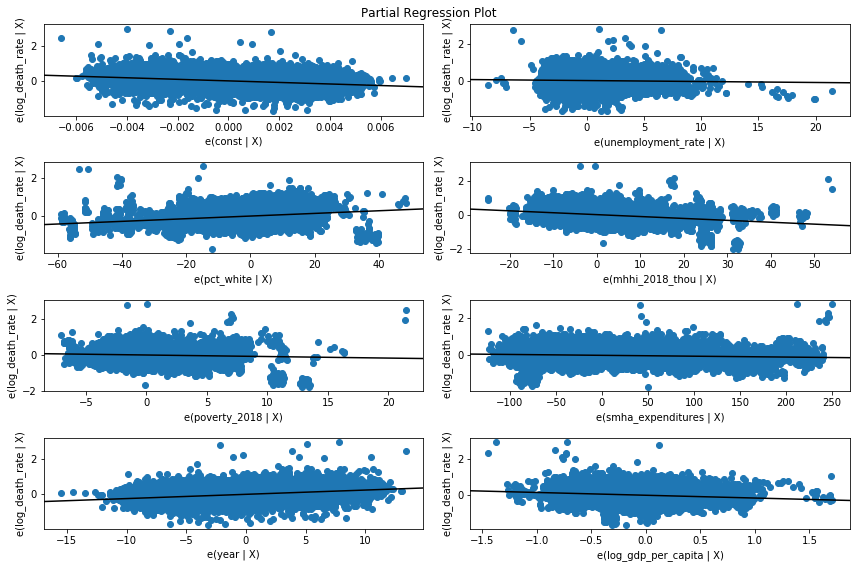

In [5]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)

In [6]:
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

y = mhealth["log_death_rate"].to_numpy()
X = mhealth[["unemployment_rate", "pct_white",  "mhhi_2018_thou", "poverty_2018", "smha_expenditures", "year", "log_gdp_per_capita"]].to_numpy()

regr = linear_model.LinearRegression()
regr.fit(X, y)

print("Overall: Mean Squared Error = ", str(round(mean_squared_error(regr.predict(X), y), 3)))

kf = KFold(n_splits=10, random_state=None, shuffle=False)
kf.get_n_splits(X)

i = 1
for train_index, test_index in kf.split(X):
    X_train =X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test =y[test_index]
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    print("Fold " + str(i) + ": Mean Squared Error = " + str(round(mean_squared_error(y_pred, y_test), 3)))
    i = i + 1


Overall: Mean Squared Error =  0.118
Fold 1: Mean Squared Error = 0.226
Fold 2: Mean Squared Error = 0.1
Fold 3: Mean Squared Error = 0.103
Fold 4: Mean Squared Error = 0.087
Fold 5: Mean Squared Error = 0.113
Fold 6: Mean Squared Error = 0.195
Fold 7: Mean Squared Error = 0.089
Fold 8: Mean Squared Error = 0.091
Fold 9: Mean Squared Error = 0.171
Fold 10: Mean Squared Error = 0.115
